In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
# import fitsio
import pandas as pd
import time
import pickle
import re


%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [3]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load and cut data from fits file, save as .json

In [4]:
data_json_fn = '../data/data_w_dith.json'
data_fits_fn = '../data/decam-exposures-20251211_w_dith.fits'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read(data_fits_fn)
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Instantiate the offline dataset choosing binning method (healpix vs uniform_grid)

In [17]:
binning_method='healpix'
nside=32
bin_space='radec'
specific_years=[2014]
specific_months=[12]
# specific_days=[15]
# specific_years=None
specific_months = None
specific_days=None
include_default_features=True
include_bin_features=False
do_z_score_norm=True
do_cyclical_norm=True

ERROR! Session/line number was not unique in database. History logging moved to new session 1293


In [18]:
dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=specific_years,
    specific_months=specific_months,
    specific_days=specific_days,
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

# Visualize dataset in az, el and ra, dec

In [19]:
obj_names, counts = np.unique(dataset._df.object, return_counts=True)

Text(0, 0.5, 'Number of fields')

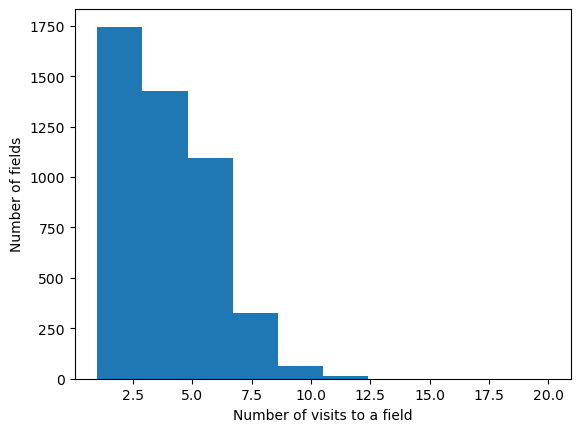

In [20]:
plt.hist(counts)
plt.xlabel('Number of visits to a field')
plt.ylabel('Number of fields')

Text(0.5, 0, 'Number of observations in a night')

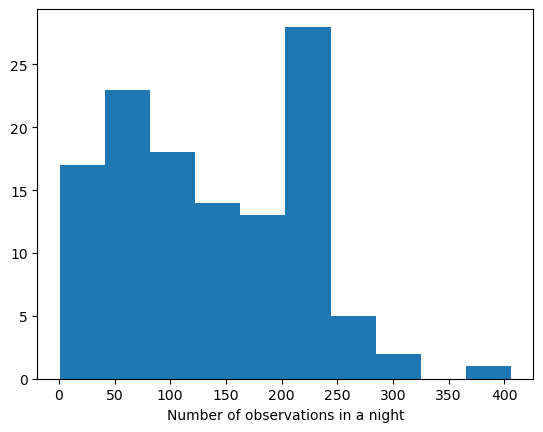

In [21]:
plt.hist(dataset.n_obs_per_night)
plt.xlabel('Number of observations in a night')

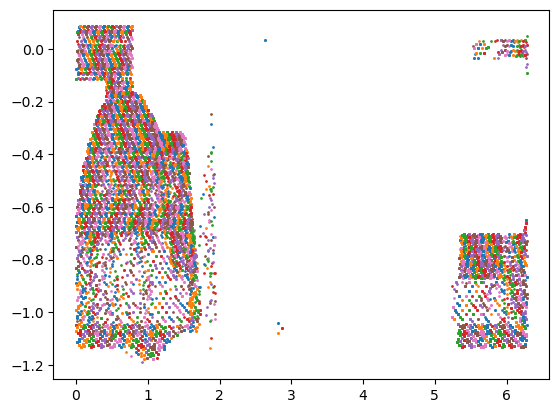

In [22]:
colors = [f'C{i}' for i in range(7)]
for i, (bin_id, g) in enumerate(dataset._df.groupby('bin')):
    plt.scatter(g.ra, g.dec, label=bin_id, color=colors[i%len(colors)], s=1)

# Train

In [23]:
batch_size = 1024//2
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [24]:
"""Algorithm and Train setup"""
exp_name_prefix = 'v1f-environment-testing'

bc_alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 4096//2//2,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**bc_alg_config)

# ddqn_alg_config = {
#     'obs_dim': dataset.obs_dim,
#     'num_actions': dataset.num_actions,
#     'hidden_dim': 128,
#     'device': device,
#     'gamma': .95,
#     'tau': 1e-4,
#     'lr': 1e-3,
#     'loss_fxn': None,
#     use_double=True,
# }
# alg = DDQN(**ddqn_alg_config)

fit_config = {
    'num_epochs' : 5,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'OfflineEnv'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config, prefix=None):
    if prefix is not None:
        exp_name = prefix
    else:
        exp_name = ''
    exp_name += f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, bc_alg_config, prefix=exp_name_prefix)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': True,
    'outdir': outdir
    }

agent = Agent(**agent_config)

# Train

In [25]:
# circle on gif is a 1.1deg radius --> maybe nside = 16 is enough, (nside=32 is about a 3 deg area)

In [ ]:
overwrite_model = True

if os.path.exists(outdir + 'best_weights.pt') and not overwrite_model:
    agent.load(filepath=outdir + 'best_weights.pt')
else:
    start_time = time.time()
    """Train"""
    agent.fit(
        dataloader=trainloader,
        **fit_config
        )
    end_time = time.time()
    train_time = end_time - start_time
    print(f'Total train time = {train_time}s on {device}')

  0%|                                      | 1/82735 [00:00<16:10:23,  1.42it/s]

Train step 0: Accuracy = 0.002, Loss = 9.1111, Q-val=-0.493


  0%|                                     | 101/82735 [00:29<7:22:04,  3.12it/s]

Train step 100: Accuracy = 0.107, Loss = 4.0427, Q-val=-15.222


  0%|                                     | 201/82735 [00:59<7:31:46,  3.04it/s]

Train step 200: Accuracy = 0.199, Loss = 3.1477, Q-val=-17.698


  0%|▏                                    | 301/82735 [01:27<7:29:39,  3.06it/s]

Train step 300: Accuracy = 0.285, Loss = 2.5876, Q-val=-19.137


  0%|▏                                    | 401/82735 [01:54<8:07:35,  2.81it/s]

Train step 400: Accuracy = 0.326, Loss = 2.3488, Q-val=-21.061


  1%|▏                                    | 501/82735 [02:22<7:38:15,  2.99it/s]

Train step 500: Accuracy = 0.418, Loss = 1.9022, Q-val=-22.215


  1%|▎                                    | 601/82735 [02:52<7:44:53,  2.94it/s]

Train step 600: Accuracy = 0.471, Loss = 1.7636, Q-val=-22.447


  1%|▎                                    | 701/82735 [03:21<8:56:10,  2.55it/s]

Train step 700: Accuracy = 0.520, Loss = 1.4552, Q-val=-23.700


  1%|▎                                    | 801/82735 [03:49<8:01:59,  2.83it/s]

Train step 800: Accuracy = 0.537, Loss = 1.3448, Q-val=-23.503


  1%|▍                                    | 901/82735 [04:17<7:49:05,  2.91it/s]

Train step 900: Accuracy = 0.604, Loss = 1.3076, Q-val=-24.053


  1%|▍                                   | 1001/82735 [04:47<8:39:14,  2.62it/s]

Train step 1000: Accuracy = 0.629, Loss = 1.1540, Q-val=-24.671


  1%|▍                                   | 1101/82735 [05:14<8:12:22,  2.76it/s]

Train step 1100: Accuracy = 0.631, Loss = 1.0546, Q-val=-25.684


  1%|▌                                   | 1201/82735 [05:44<7:42:39,  2.94it/s]

Train step 1200: Accuracy = 0.684, Loss = 0.9334, Q-val=-25.484


  2%|▌                                   | 1301/82735 [06:12<7:38:16,  2.96it/s]

Train step 1300: Accuracy = 0.719, Loss = 0.8463, Q-val=-26.041


  2%|▌                                   | 1401/82735 [06:39<6:34:39,  3.43it/s]

Train step 1400: Accuracy = 0.707, Loss = 0.8779, Q-val=-26.702


  2%|▋                                   | 1501/82735 [07:07<7:35:33,  2.97it/s]

Train step 1500: Accuracy = 0.764, Loss = 0.6773, Q-val=-27.241


  2%|▋                                   | 1601/82735 [07:34<6:40:15,  3.38it/s]

Train step 1600: Accuracy = 0.766, Loss = 0.6898, Q-val=-27.670


  2%|▋                                   | 1701/82735 [08:01<6:39:31,  3.38it/s]

Train step 1700: Accuracy = 0.787, Loss = 0.6777, Q-val=-27.467


  2%|▊                                   | 1801/82735 [08:29<7:18:13,  3.08it/s]

Train step 1800: Accuracy = 0.787, Loss = 0.6257, Q-val=-28.094


  2%|▊                                   | 1901/82735 [08:57<8:22:52,  2.68it/s]

Train step 1900: Accuracy = 0.803, Loss = 0.6250, Q-val=-28.345


  2%|▊                                   | 2001/82735 [09:24<7:23:28,  3.03it/s]

Train step 2000: Accuracy = 0.846, Loss = 0.5284, Q-val=-28.594


  3%|▉                                   | 2101/82735 [09:52<7:41:37,  2.91it/s]

Train step 2100: Accuracy = 0.834, Loss = 0.5099, Q-val=-28.930


  3%|▉                                   | 2201/82735 [10:19<7:14:05,  3.09it/s]

Train step 2200: Accuracy = 0.828, Loss = 0.5063, Q-val=-29.302


  3%|█                                   | 2301/82735 [10:47<7:36:02,  2.94it/s]

Train step 2300: Accuracy = 0.832, Loss = 0.4825, Q-val=-29.176


  3%|█                                   | 2401/82735 [11:15<7:23:03,  3.02it/s]

Train step 2400: Accuracy = 0.891, Loss = 0.3715, Q-val=-29.309


  3%|█                                   | 2501/82735 [11:42<6:48:26,  3.27it/s]

Train step 2500: Accuracy = 0.875, Loss = 0.4020, Q-val=-29.439


  3%|█                                   | 2541/82735 [11:54<6:13:45,  3.58it/s]

In [18]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

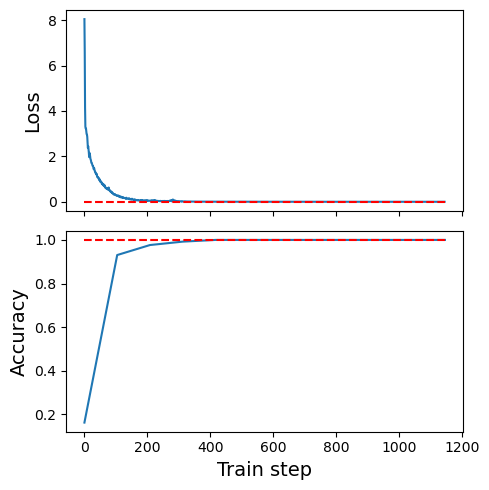

In [19]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Roll out policy

In [20]:
test_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=specific_years,
    specific_months=specific_months,
    specific_days=specific_days,
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

## Using gym.env

In [21]:
from survey_ops.src.environments import OfflineEnv

In [22]:
gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=OfflineEnv,
    max_episode_steps=10000,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

# for eval step only
env_config = {
    'id': f"gymnasium_env/{env_name}",
    'train_dataset': dataset,
    'test_dataset': test_dataset,
    'max_nights': None,
    'field_choice_method': 'random'
}

env = gym.make(**env_config)

## Some small checks of environment

In [66]:
state, info = env.reset()

In [67]:
for a, b in zip(dataset._df['el'].values, np.pi/2 - dataset._df['zd'].values):
    print(type(a), type(b), a, b, a == b)

<class 'numpy.float32'> <class 'numpy.float32'> 1.3407619 1.340762 False
<class 'numpy.float32'> <class 'numpy.float32'> 1.2952088 1.2952089 False
<class 'numpy.float32'> <class 'numpy.float32'> 1.3297664 1.3297664 True
<class 'numpy.float32'> <class 'numpy.float32'> 1.3533283 1.3533283 True
<class 'numpy.float32'> <class 'numpy.float32'> 0.99291784 0.99291784 True
<class 'numpy.float32'> <class 'numpy.float32'> 0.9876818 0.98768187 False
<class 'numpy.float32'> <class 'numpy.float32'> 0.98715824 0.98715824 True
<class 'numpy.float32'> <class 'numpy.float32'> 0.99745566 0.9974557 False
<class 'numpy.float32'> <class 'numpy.float32'> 0.9990265 0.99902654 False
<class 'numpy.float32'> <class 'numpy.float32'> 1.0019935 1.0019937 False
<class 'numpy.float32'> <class 'numpy.float32'> 0.96446896 0.964469 False
<class 'numpy.float32'> <class 'numpy.float32'> 0.9515535 0.9515535 True
<class 'numpy.float32'> <class 'numpy.float32'> 0.9983283 0.9983284 False
<class 'numpy.float32'> <class 'numpy

In [68]:
state, info = env.reset()

In [69]:
env.unwrapped._state == test_dataset.next_states[0]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

In [70]:
env.unwrapped._bin_num

np.int32(2146)

In [71]:
test_dataset._df.bin[:2]

27072    2146
27073    2018
Name: bin, dtype: int32

In [72]:
next_state, reward, terminated, truncated, info = env.step(2018)

In [73]:
for b, feat_name in zip(test_dataset.next_states[1] == next_state, test_dataset.state_feature_names):
    print(feat_name, b)

ra_cos tensor(False)
ra_sin tensor(False)
dec tensor(False)
az_cos tensor(False)
az_sin tensor(False)
el tensor(False)
airmass tensor(False)
ha_cos tensor(False)
ha_sin tensor(False)
sun_ra_cos tensor(True)
sun_ra_sin tensor(True)
sun_dec tensor(True)
sun_az_cos tensor(False)
sun_az_sin tensor(False)
sun_el tensor(False)
moon_ra_cos tensor(True)
moon_ra_sin tensor(True)
moon_dec tensor(True)
moon_az_cos tensor(False)
moon_az_sin tensor(False)
moon_el tensor(False)
time_fraction_since_start tensor(True)


In [74]:
next_state[7]

np.float32(0.207767)

In [75]:
from survey_ops.utils import ephemerides

In [79]:
state

array([ 0.96967417,  0.24440128, -0.17097504,  0.48579392, -0.8740734 ,
        4.108588  , -3.0060616 ,  0.9999624 ,  0.00867128, -0.11922491,
       -0.9928673 ,  1.7958946 ,  0.08713816, -0.9961962 ,  1.8453486 ,
       -0.9950016 , -0.09985889,  1.734092  , -0.23677549, -0.9715644 ,
        2.5307524 ,  0.        ], dtype=float32)

In [80]:
env.unwrapped.state_feature_names

['ra_cos',
 'ra_sin',
 'dec',
 'az_cos',
 'az_sin',
 'el',
 'airmass',
 'ha_cos',
 'ha_sin',
 'sun_ra_cos',
 'sun_ra_sin',
 'sun_dec',
 'sun_az_cos',
 'sun_az_sin',
 'sun_el',
 'moon_ra_cos',
 'moon_ra_sin',
 'moon_dec',
 'moon_az_cos',
 'moon_az_sin',
 'moon_el',
 'time_fraction_since_start']

In [81]:
# state, info = env.reset()
# episode_reward = 0
# terminated = False
# truncated = False
# state_list = [state]
# rewards_list = [0]

# i = 0
# while not (terminated or truncated):
#     with torch.no_grad():
#         # if env.unwrapped._night_idx != 0:
#         #     print(env.unwrapped._night_idx)
#         action_mask = info.get('action_mask', None)
#         action = agent.act(state, action_mask, epsilon=None)  # greedy
#         state, reward, terminated, truncated, info = env.step(action)
#         state_list.append(state)
#         # rewards_list.append(reward)
#         # episode_reward += reward
        # i += 1

## Evaluate agent given environment

In [47]:
agent.evaluate(env=env, num_episodes=10)
with open(outdir + 'eval_metrics.pkl', 'rb') as handle:
    eval_metrics = pickle.load(handle)

 10%|████▍                                       | 1/10 [00:00<00:02,  3.87it/s]

terminated at 226


 20%|████████▊                                   | 2/10 [00:00<00:02,  3.92it/s]

terminated at 226


 30%|█████████████▏                              | 3/10 [00:00<00:01,  3.89it/s]

terminated at 226


 40%|█████████████████▌                          | 4/10 [00:01<00:01,  3.90it/s]

terminated at 226


 50%|██████████████████████                      | 5/10 [00:01<00:01,  4.05it/s]

terminated at 226


 60%|██████████████████████████▍                 | 6/10 [00:01<00:00,  4.23it/s]

terminated at 226


 70%|██████████████████████████████▊             | 7/10 [00:01<00:00,  4.21it/s]

terminated at 226


 80%|███████████████████████████████████▏        | 8/10 [00:01<00:00,  4.30it/s]

terminated at 226


 90%|███████████████████████████████████████▌    | 9/10 [00:02<00:00,  4.19it/s]

terminated at 226


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.14it/s]

terminated at 226
eval_metrics.pkl saved in ../results/v1f-environment-testingBehaviorCloning-OfflineEnv-n_nights=1-num_epochs=5-batch_size=1024-lr=0.003/


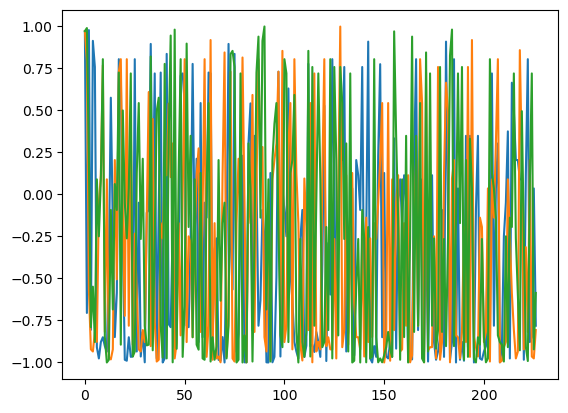

In [52]:
plt.plot(eval_metrics['observations']['ep-0'].T[0])
plt.plot(eval_metrics['observations']['ep-1'].T[0])
plt.plot(eval_metrics['observations']['ep-9'].T[0])


In [ ]:
eval_metrics['bin']

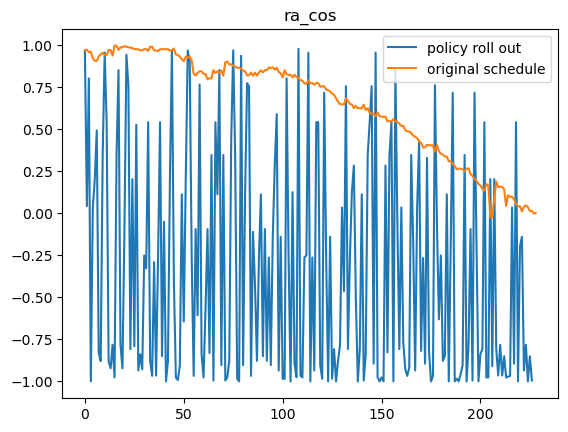

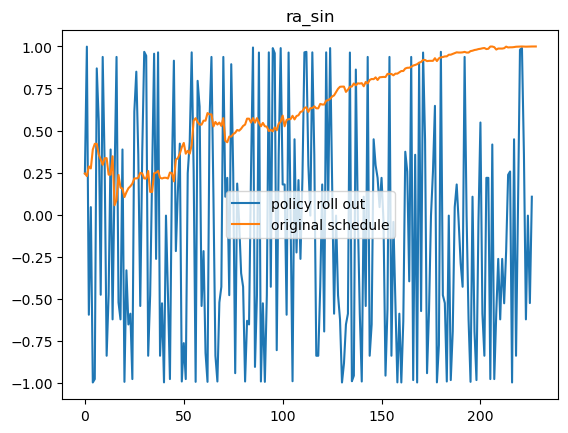

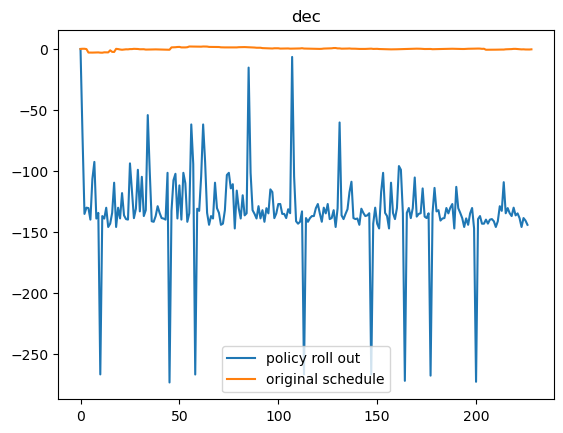

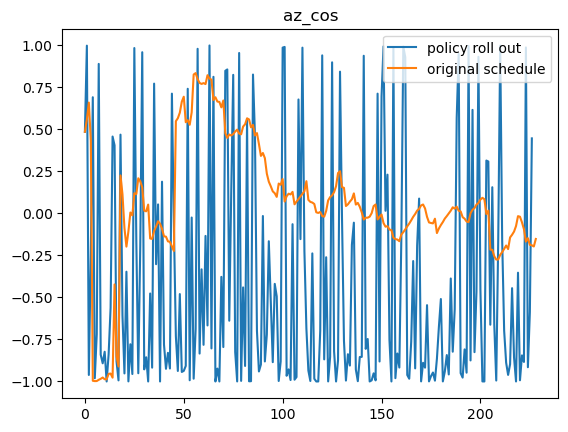

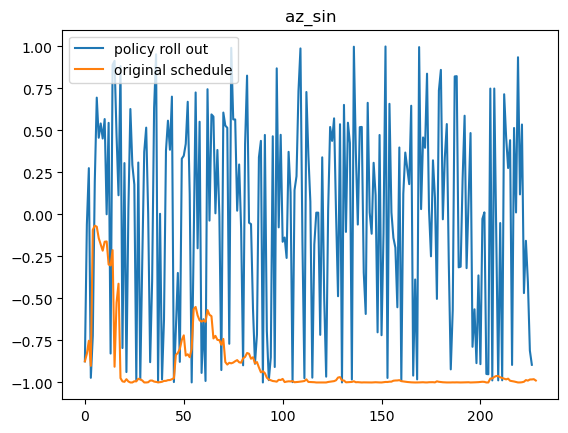

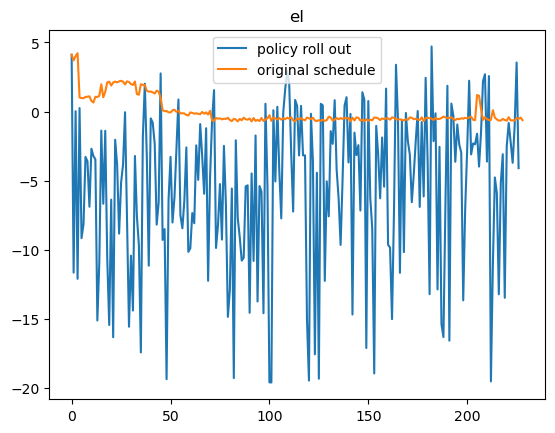

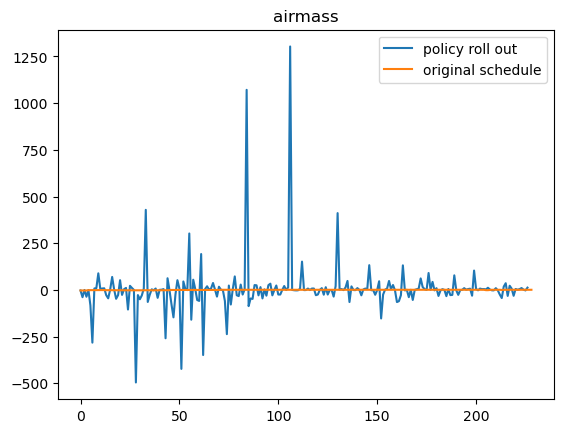

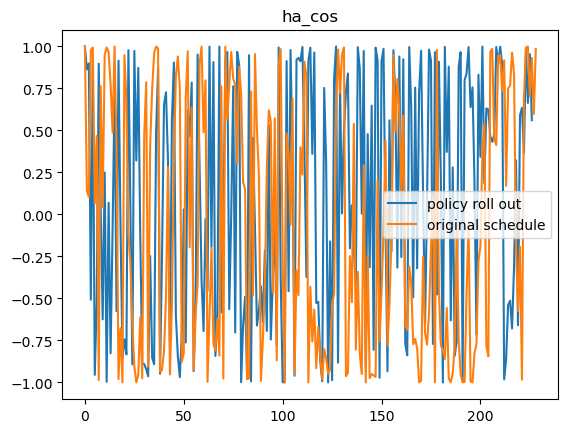

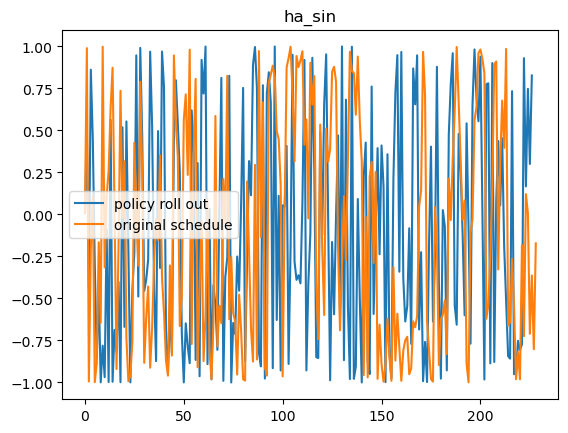

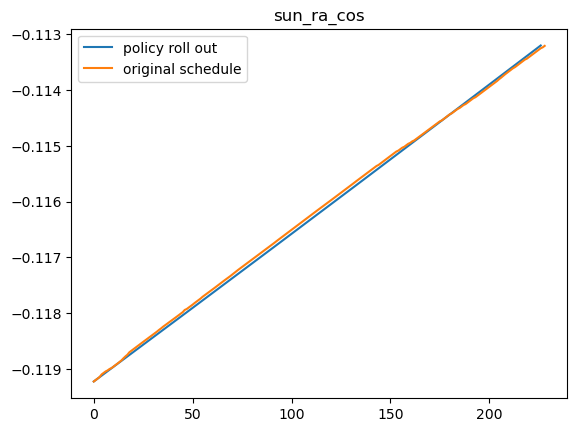

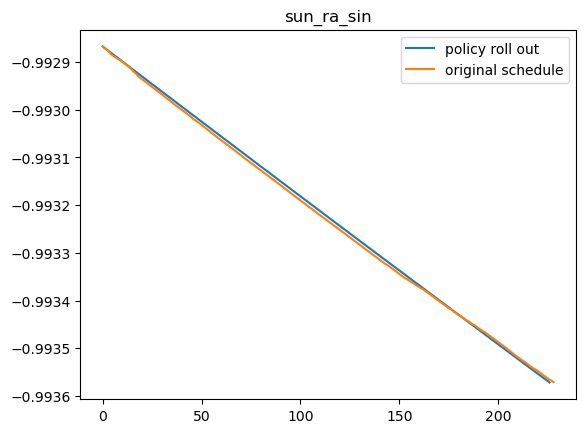

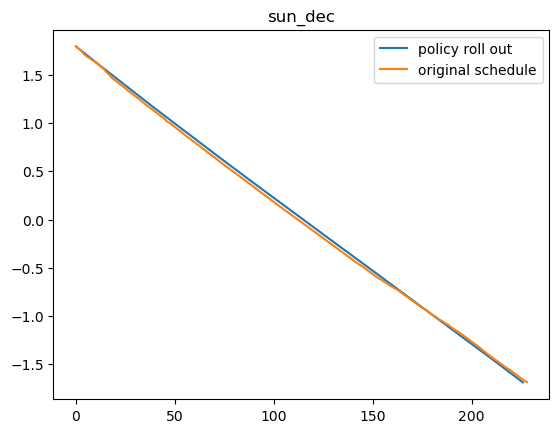

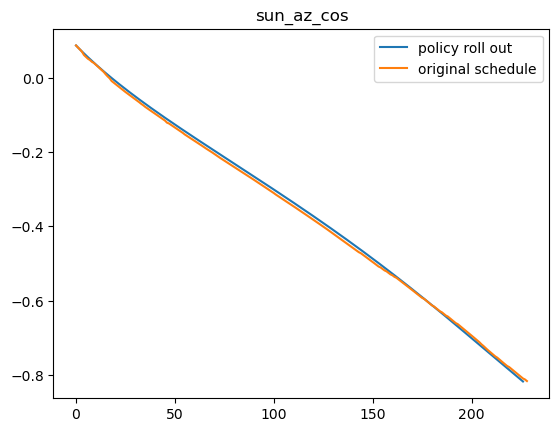

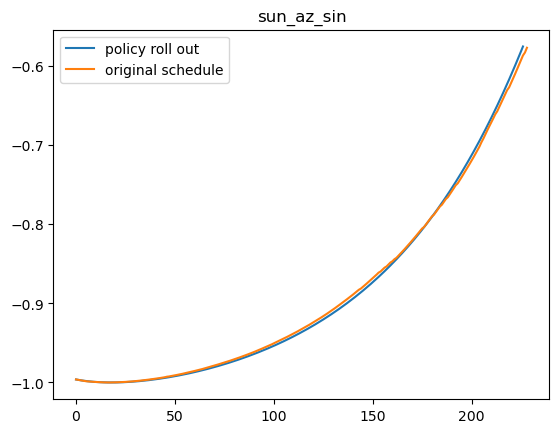

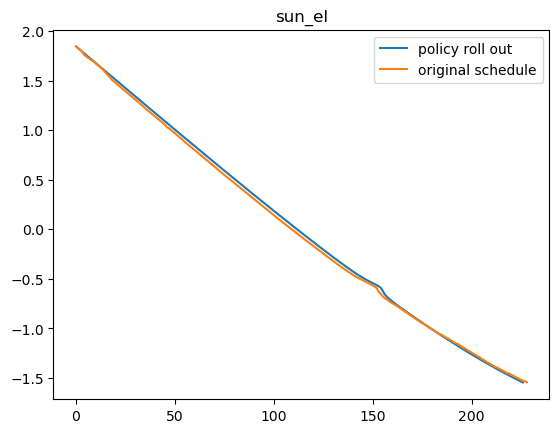

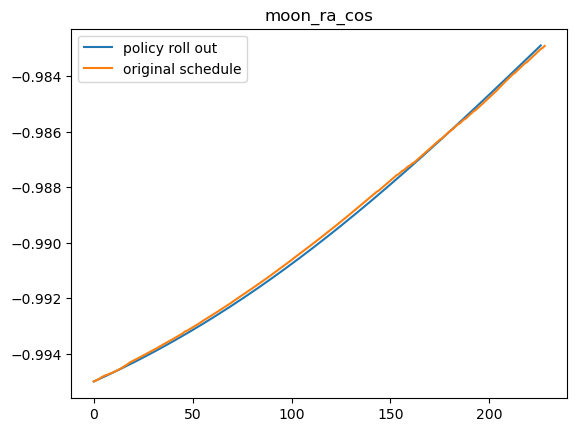

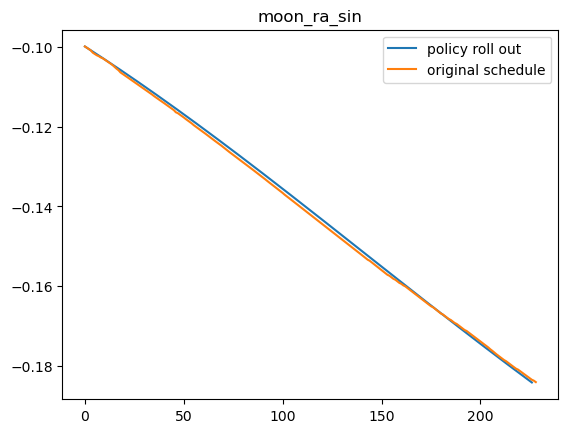

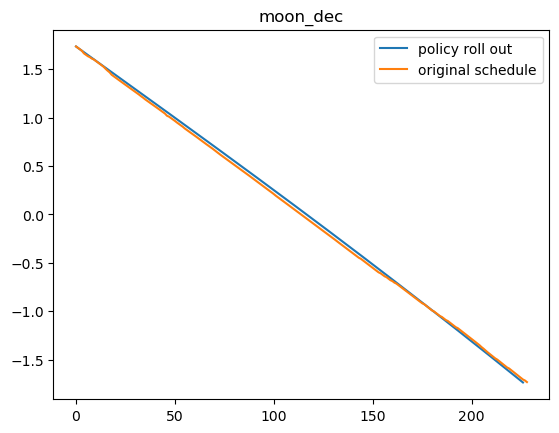

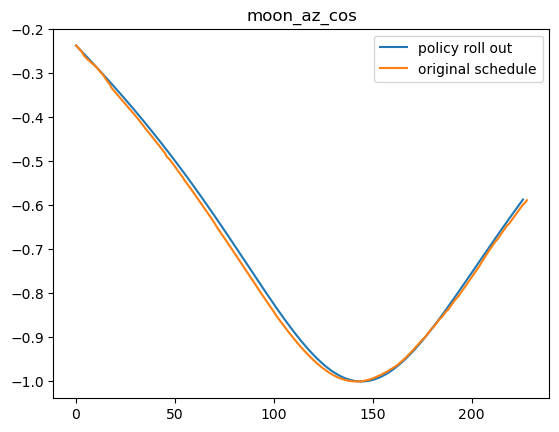

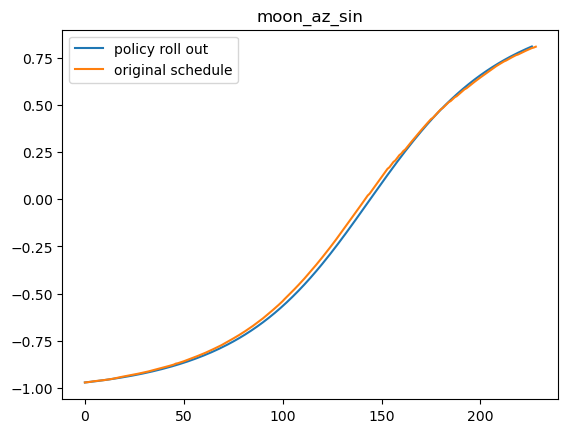

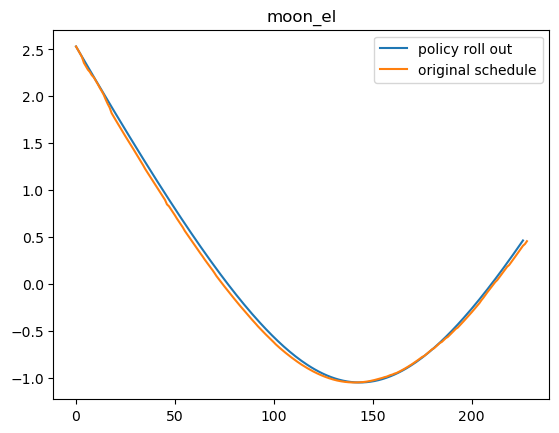

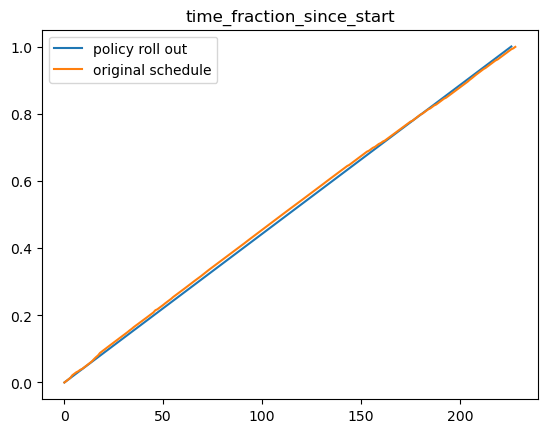

In [24]:
for i, feature_row in enumerate(eval_metrics['observations']['ep-0'].T):
    plt.plot(feature_row, label='policy roll out')
    plt.plot(test_dataset.next_states[:, i], label='original schedule')
    plt.title(test_dataset.state_feature_names[i])
    plt.legend()
    plt.show();

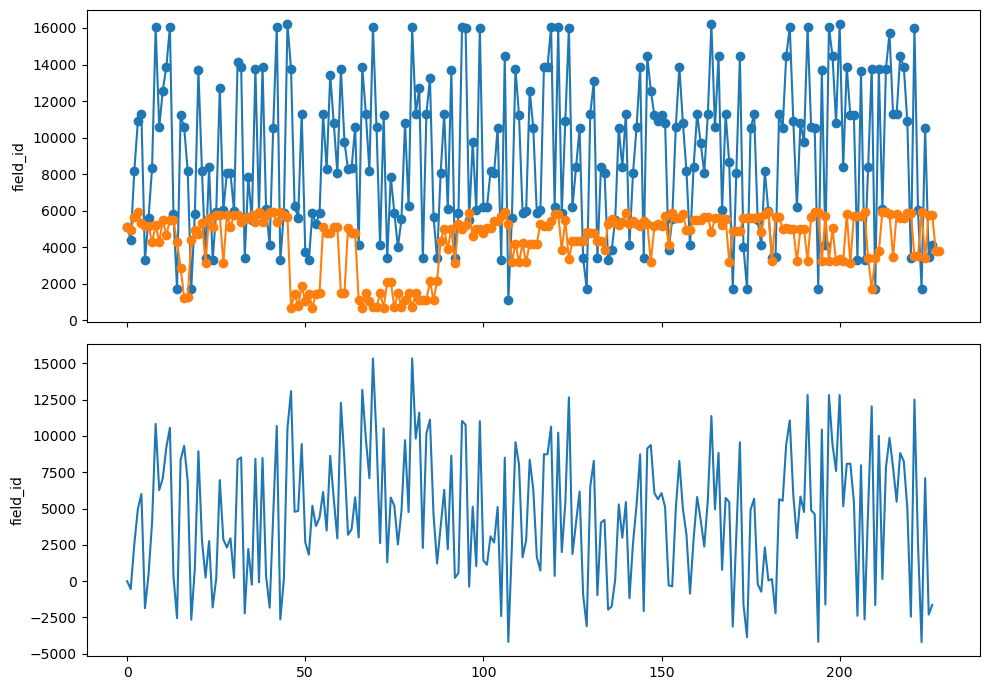

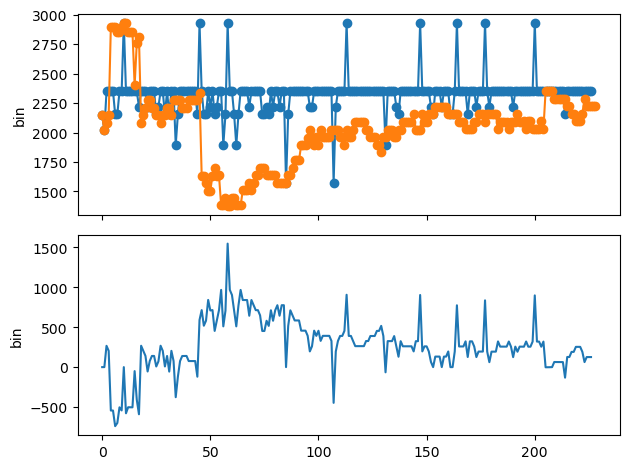

In [46]:
fig_f, axs_f = plt.subplots(2, figsize=(10,7), sharex=True)
fig_b, axs_b = plt.subplots(2, sharex=True)
for ax, metric in zip([axs_f, axs_b], ['field_id', 'bin']):
    ax[0].plot(eval_metrics[metric]['ep-0'].astype(int), marker='o', label='pred')
    ax[0].plot(test_dataset._df[metric].values.astype(int), marker='o', label='true')
    ax[1].plot(eval_metrics[metric]['ep-0'].astype(int) - test_dataset._df[metric].values.astype(int)[:-2])
    for _ax in ax:
        _ax.set_ylabel(metric)
fig_f.tight_layout()
fig_b.tight_layout()

In [26]:
eval_bin_radecs = np.array([dataset.field2radec[bin_num] for bin_num in eval_metrics['bin']['ep-0'].astype(int)])
orig_bin_racecs = np.array([dataset.field2radec[bin_num] for bin_num in test_dataset._df['bin'].values])

Text(0, 0.5, 'dec')

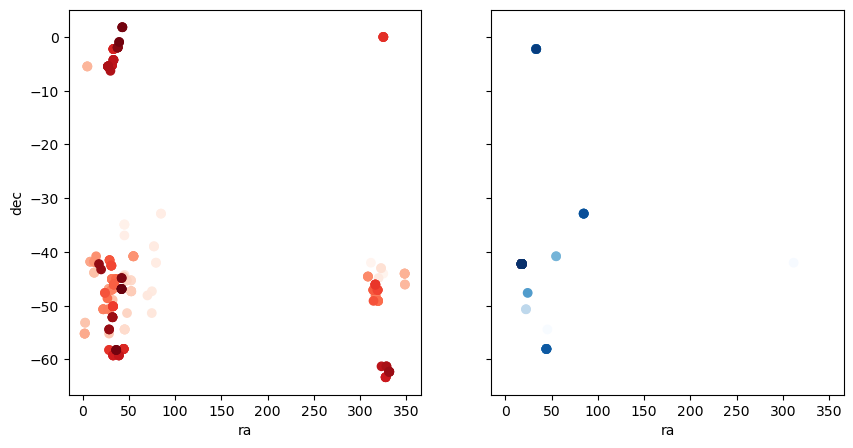

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
axs[0].scatter(orig_bin_racecs[:, 0], orig_bin_racecs[:, 1], label='orig schedule', cmap='Reds', c=np.arange(len(orig_bin_racecs)))
axs[1].scatter(eval_bin_radecs[:, 0], eval_bin_radecs[:, 1], label='policy roll out', cmap='Blues', c=np.arange(len(eval_bin_radecs)))
for ax in axs:
    ax.set_xlabel('ra')
axs[0].set_ylabel('dec')

In [29]:
# schedule file: columns `time` and `field_id`
# bin_schedule file: "time", "policy_bin_id", and "bin_id"

In [62]:
eval_field_schedule = {
    'time': eval_metrics['timestamps']['ep-0'],
    'field_id': eval_metrics['field_id']['ep-0']
}
orig_field_schedule = {
    'time': test_dataset._df['timestamp'].values,
    'field_id': test_dataset._df['field_id'].values
}
bin_schedule = {
    'time': test_dataset._df['timestamp'].values[:-2],
    'policy_bin_id': test_dataset._df['bin'].values[:-2],
    'bin_id': eval_metrics['bin']['ep-0']
}

In [63]:
for val in bin_schedule.values():
    print(len(val))

227
227
227


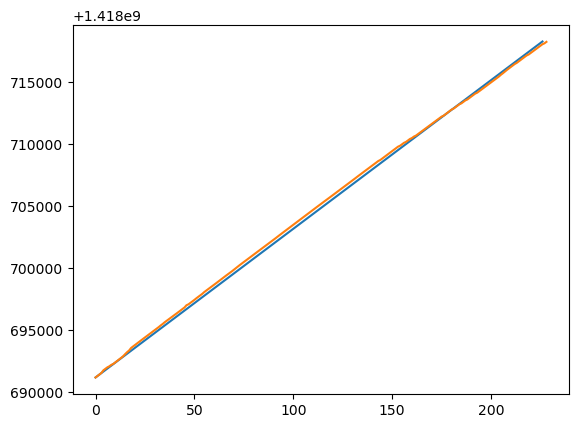

In [64]:
plt.plot(eval_metrics['timestamps']['ep-0'])
plt.plot(test_dataset._df['timestamp'].values)

In [69]:
nside

16

In [68]:
schedule_outdir = '../results/v2f-environment-testing/'
if not os.path.exists(schedule_outdir):
    os.makedirs(schedule_outdir)
for data, filename in zip(
    [orig_field_schedule, eval_field_schedule, bin_schedule],
    ['original_schedule.csv', 'eval_schedule.csv', 'bin_schedule.csv']
    ):
    df = pd.DataFrame(data)
    output_filepath = '../results/v2f-environment-testing/' + filename
    with open(output_filepath, 'w') as f:
        df.to_csv(f, index=False)

In [129]:
len(eval_bin_radecs)

227

In [130]:
len(orig_bin_racecs)

229

In [39]:
schedule_outdir

'../results/v2f-environment-testing/'

Actually, instead of getting the trajectory, here we're just giving all of the original schedule's states, and asking what action we should pick

## Instead of trajectory, send agent batch of all states to get best next action

In [34]:
with torch.no_grad():
    q_vals = agent.algorithm.policy_net(dataset.states.to(device))
    eval_actions = torch.argmax(q_vals, dim=1).to('cpu')
    

In [35]:
# get index of the first observation for each night
first_obs_in_night_indices = []
for key, indices in dataset._df.groupby('night').indices.items():
    first_obs_in_night_indices.append(indices[0])

In [36]:
# Sequence of actions from target (original schedule) and policy
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions

# # Given the action (bin) chosen in the original schedule and in the policy's schedule
# # obtain the angular separation between the two bins for all actions
# target_radec = np.array([dataset.binid2radec[bin_id] for bin_id in target_sequence])
# eval_radec = np.array([dataset.binid2radec[bin_id] for bin_id in eval_sequence])
# # target_angsep = np.array([angular_separation(pos1=target_radec[i]*units.deg, pos2=target_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# # eval_angsep = np.array([angular_separation(pos1=eval_radec[i]*units.deg, pos2=eval_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# target_eval_angsep = np.array([angular_separation(eval_radec[i]*units.deg, pos2=target_radec[i]*units.deg) for i in range(len(target_radec))]) / units.deg

/tmp/ipykernel_89998/2214430616.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)


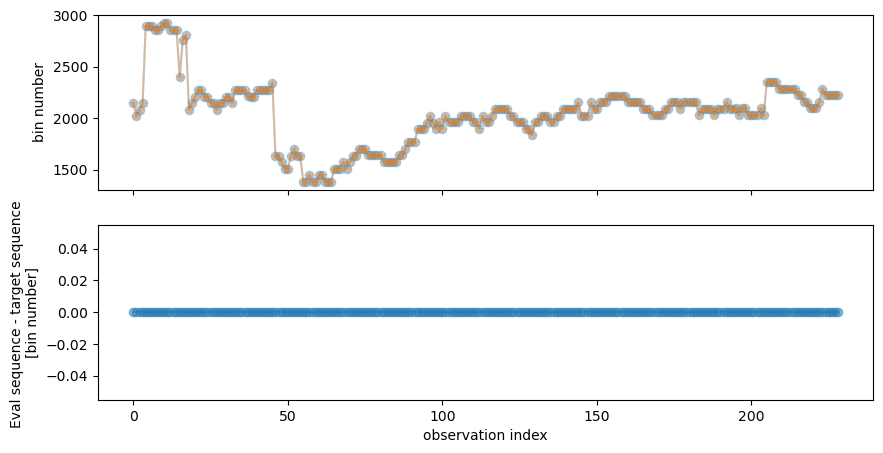

In [37]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(eval_sequence, marker='o', alpha=.3)
axs[0].plot(target_sequence, marker='*', alpha=.3)
axs[0].set_ylabel('bin number')
axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence \n[bin number]')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'train_eval_and_target_bin_sequences.png')

In [38]:
df.columns

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program',
       'object', 'teff', 'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass',
       'qc_fwhm', 'qc_cloud', 'qc_sky', 'qc_teff', 'night'],
      dtype='object')

Text(0.5, 0, 'teff')

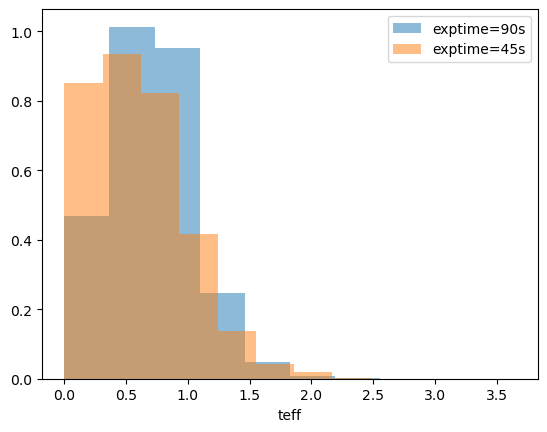

In [39]:
# plt.hist(df['teff'][df['exptime'] == 90], label='exptime=90s', density=True, alpha=.5)
plt.hist(df['qc_teff'][df['exptime'] == 90], label='exptime=90s', density=True, alpha=.5)
# plt.hist(df['teff'][df['exptime'] == 45], label='exptime=45s', density=True, alpha=.5)
plt.hist(df['qc_teff'][df['exptime'] == 45], label='exptime=45s', density=True, alpha=.5)
plt.legend()
plt.xlabel('teff')

In [45]:
df['ra']

0        301.199042
1        300.851117
2        300.460079
3        300.016742
4        302.722079
            ...    
88613     58.930033
88614     58.929917
88615     53.414579
88616     53.389708
88617     53.389546
Name: ra, Length: 88618, dtype: float64

In [46]:
[col for col in df.columns if type(df[col].values) != str and col != 'night' and col]

['expnum',
 'ra',
 'dec',
 'exptime',
 'filter',
 'propid',
 'program',
 'object',
 'teff',
 'fwhm',
 'datetime',
 'az',
 'zd',
 'ha',
 'airmass',
 'qc_fwhm',
 'qc_cloud',
 'qc_sky',
 'qc_teff']

In [47]:
[df[key].values.dtype for key in df.columns]

[dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('<M8[ns]'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('<M8[ns]')]

In [48]:
corr_mat = df[[col for col in df.columns if (df[col].values.dtype == np.float64 or df[col].values.dtype == np.int64) and col != 'qc_fwhm' and col != 'qc_teff']].corr()

In [49]:
corr_mat.style.background_gradient(cmap='coolwarm').format(precision=2)

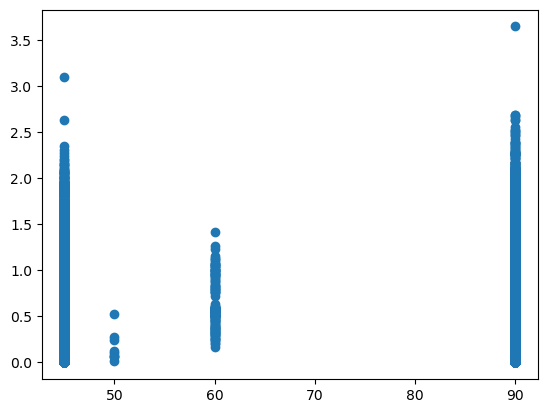

In [50]:
plt.scatter(df['exptime'], df['teff'])

In [51]:
for obj, g in df.groupby('object'):
    print(obj, g[['exptime', 'teff']])

        exptime  teff
31705       90  0.44
31706       90  0.42
31707       90  0.41
31708       90  0.36
31709       90  0.47
31710       90  0.34
31711       90  0.43
31712       90  0.41
31713       90  0.51
31714       90  0.49
31715       90  0.58
31716       90  0.60
31717       90  0.62
31718       90  0.61
31719       90  0.51
31720       90  0.54
31721       90  0.44
31722       90  0.51
Alhambra-8 hex 001 tiling 1        exptime  teff
47509       90  0.63
47510       90  0.59
47783       90  0.60
47784       90  0.81
47785       45  1.00
Alhambra-8 hex 001 tiling 10        exptime  teff
47527       90  0.59
47528       90  0.61
47810       90  0.79
47811       90  0.93
47812       45  1.25
Alhambra-8 hex 001 tiling 2        exptime  teff
47511       90  0.71
47512       90  0.70
47786       90  0.81
47787       90  0.84
47788       45  1.03
Alhambra-8 hex 001 tiling 3        exptime  teff
47513       90  0.71
47514       90  0.59
47789       90  0.79
47790       90  1.02
4779

In [53]:
dataset._df.columns

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program',
       'object', 'teff', 'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass',
       'qc_fwhm', 'qc_cloud', 'qc_sky', 'qc_teff', 'night', 'timestamp',
       'sun_ra', 'sun_dec', 'sun_az', 'sun_el', 'moon_ra', 'moon_dec',
       'moon_az', 'moon_el', 'time_fraction_since_start', 'ra_cos', 'ra_sin',
       'az_cos', 'az_sin', 'ha_cos', 'ha_sin', 'sun_ra_cos', 'sun_ra_sin',
       'sun_az_cos', 'sun_az_sin', 'moon_ra_cos', 'moon_ra_sin', 'moon_az_cos',
       'moon_az_sin', 'el', 'bin', 'field_id'],
      dtype='object')

In [54]:
test_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=[2015],
    specific_months=[12],
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

In [55]:
with torch.no_grad():
    test_q_vals = agent.algorithm.policy_net(test_dataset.states.to(device))
    test_eval_actions = torch.argmax(test_q_vals, dim=1).to('cpu')

test_target_sequence = test_dataset.actions.detach().numpy()
test_eval_sequence = test_eval_actions.detach().numpy()

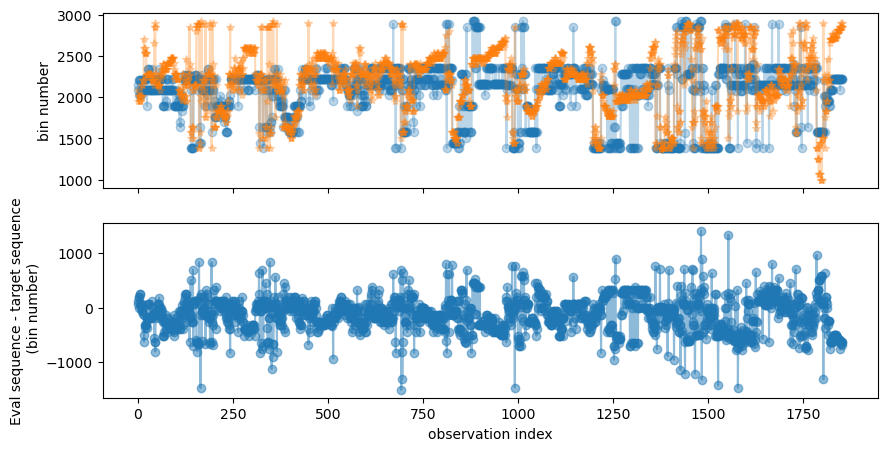

In [56]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(test_eval_sequence, marker='o', alpha=.3)
axs[0].plot(test_target_sequence, marker='*', alpha=.3)
axs[0].set_ylabel('bin number')
axs[1].plot(test_eval_sequence - test_target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence\n (bin number)')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'test_eval_and_target_bin_sequences.png')

In [57]:
import random

In [58]:
test_eval_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in test_eval_sequence])
test_target_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in test_target_sequence])

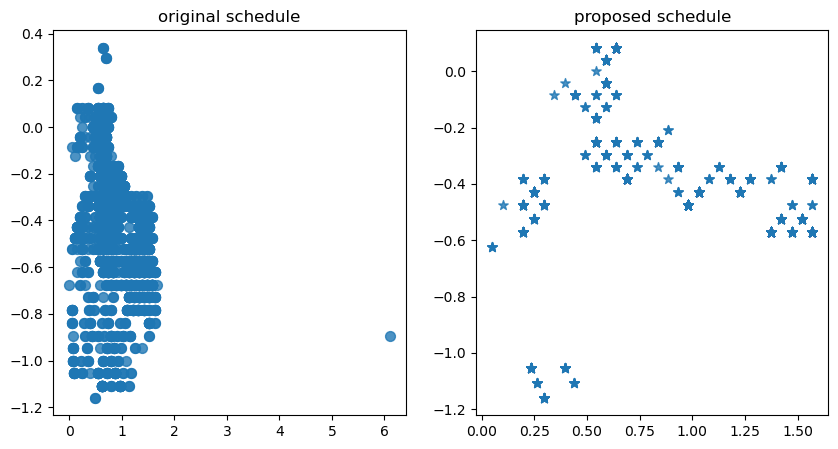

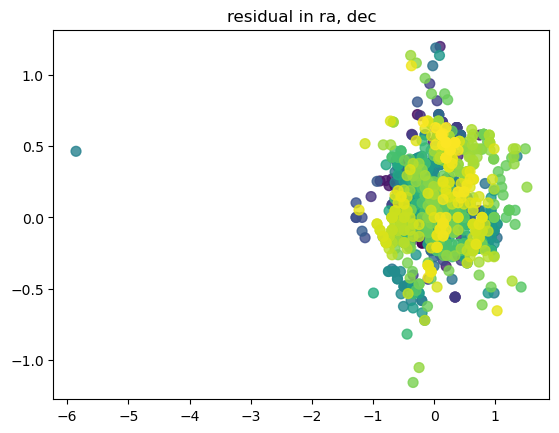

In [59]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].scatter(test_target_bin_radecs[:, 0], test_target_bin_radecs[:, 1], s=50, alpha=.8)
axs[1].scatter(test_eval_bin_radecs[:, 0], test_eval_bin_radecs[:, 1], alpha=.8, s=50, marker='*')
axs[0].set_title('original schedule')
axs[1].set_title('proposed schedule')
plt.show();

plt.scatter(test_eval_bin_radecs[:, 0] - test_target_bin_radecs[:, 0], test_eval_bin_radecs[:, 1] - test_target_bin_radecs[:, 1], s=50, c=np.arange(len(test_dataset)), alpha=.8)
plt.title('residual in ra, dec')
plt.show();
